# Matching experiments in spiny

In [1]:

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graspologic.match import graph_match
from pkg.io import FIG_PATH, OUT_PATH
from pkg.data import DATA_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from scipy.io import mmread
from scipy.sparse import csr_array
from tqdm.autonotebook import tqdm
from git import Repo
from giskard.plot import confusionplot

DISPLAY_FIGS = True

FILENAME = "spiny_match_check_errors"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


graspologic_path = "/Users/bpedigo/JHU_code/neuro-matching/graspologic"
graspologic_repo = Repo(graspologic_path)
print("Using new graph matching implementation under development, see PR:")
print("https://github.com/microsoft/graspologic/pull/960")
print(f"Current graspologic branch: {graspologic_repo.active_branch.name}")
print(f"Current graspologic commit hash: {graspologic_repo.head.commit}")

t0 = time.time()
set_theme()
rng = np.random.default_rng(888)
np.random.seed(8888)

Using new graph matching implementation under development, see PR:
https://github.com/microsoft/graspologic/pull/960
Current graspologic branch: new-gm
Current graspologic commit hash: 07a0ede2e6c26db0d7719c6087f4a99c0966422e


## Load the data

In [2]:
meta_loc = DATA_PATH / "spiny/meta_adj_spiny_big.csv"
meta = pd.read_csv(meta_loc, index_col=0)
meta["bodyid"] = meta["bodyid"].astype(int)
meta["group"] = meta["group"].astype("Int64")
meta = meta.set_index("bodyid")

adj_loc = DATA_PATH / "spiny/adj_spiny_big.mtx"
adj_dense = mmread(adj_loc).toarray()
adj_df = pd.DataFrame(data=adj_dense, index=meta.index, columns=meta.index)

## Selecting subsets of the data for some experiments

In [3]:


def select_paired_neuromere(meta, neuromere):
    # select the neuromere
    select_meta = meta[meta["soma_neuromere"].isin([neuromere])]

    # count occurences of "group"
    group_counts = select_meta["group"].value_counts()

    # find everything that occurs only twice
    single_group_counts = group_counts[group_counts == 2].index

    # subselect to these which are paired
    select_meta = select_meta[select_meta["group"].isin(single_group_counts)]
    select_meta = select_meta.sort_values("group")

    # split left right
    left_meta = select_meta[select_meta["soma_side"] == "LHS"]
    right_meta = select_meta[select_meta["soma_side"] == "RHS"]

    # grab subset for which we have on both left and right
    # because of filter above, these are the cases where we have one on right and left
    groups_in_both = np.intersect1d(left_meta["group"], right_meta["group"])
    left_meta = left_meta[left_meta["group"].isin(groups_in_both)]
    right_meta = right_meta[right_meta["group"].isin(groups_in_both)]

    # ensure indexed the same, useful assumption later
    assert left_meta["group"].values == right_meta["group"].values

    return left_meta, right_meta


def select_adjacency(source, target=None, sparse=False):
    if target is None:
        target = source
    sub_adjacency = adj_df.loc[source, target].values
    if sparse:
        sub_adjacency = csr_array(sub_adjacency)
    return sub_adjacency

In [4]:

RERUN = True

n_seeds = 0
neuromeres = ["T1"]  # "T2", "T3"]
sparse = True
transport = False
bilateral = True
n_repeats = 1

if RERUN:
    matches = []
    rows = []
    with tqdm(total=len(neuromeres) * n_repeats) as pbar:
        for neuromere in neuromeres:
            left_meta, right_meta = select_paired_neuromere(meta, neuromere)
            left_nodes = left_meta.index
            right_nodes = right_meta.index

            ll_adj = select_adjacency(left_nodes, left_nodes, sparse=sparse)
            rr_adj = select_adjacency(right_nodes, right_nodes, sparse=sparse)
            lr_adj = select_adjacency(left_nodes, right_nodes, sparse=sparse)
            rl_adj = select_adjacency(right_nodes, left_nodes, sparse=sparse)
            n = ll_adj.shape[0]

            print(f"Neuromere {neuromere} has {n} neurons per side.")

            perm = rng.permutation(n)
            undo_perm = np.argsort(perm)
            rr_adj = rr_adj[perm][:, perm]
            lr_adj = lr_adj[:, perm]
            rl_adj = rl_adj[perm]

            for trial in range(n_repeats):
                pbar.update(1)

                if bilateral:
                    AB = lr_adj
                    BA = rl_adj
                else:
                    AB = None
                    BA = None

                currtime = time.time()

                indices_l, indices_r, score, misc = graph_match(
                    A=ll_adj,
                    B=rr_adj,
                    AB=AB,
                    BA=BA,
                    transport=transport,
                    transport_regularizer=700,
                    rng=rng.integers(np.iinfo(np.uint32).max),
                    max_iter=60,
                )
                match_ratio_full = (indices_r == undo_perm).mean()
                elapsed = time.time() - currtime

                result = {
                    "match_ratio_full": match_ratio_full,
                    "n_seeds": n_seeds,
                    "elapsed": elapsed,
                    "bilateral": bilateral,
                    "transport": transport,
                    "n_iter": misc[0]["n_iter"],
                    "converged": misc[0]["converged"],
                    "n": n,
                    "neuromere": neuromere,
                    "score": score,
                }
                rows.append(result)
                perm = np.empty(n, dtype=int)
                perm[undo_perm] = indices_r
                matches.append(perm)

    results = pd.DataFrame(rows)
    results.to_csv(OUT_PATH / "simple_matching_summary.csv")
else:
    results = pd.read_csv(OUT_PATH / "simple_matching_summary.csv", index_col=0)

results

  0%|          | 0/1 [00:00<?, ?it/s]

Neuromere T1 has 1181 neurons per side.


,match_ratio_full,n_seeds,elapsed,bilateral,transport,n_iter,converged,n,neuromere,score
0,0.895004,0,6.902037,True,False,8,True,1181,T1,64921595.0


In [5]:
id_matches = []
for match in matches:
    id_matches.append(right_nodes[match])
match_df = pd.DataFrame(id_matches).T
match_df.set_index(left_nodes)

# avg_n_unique = 0
# for idx, row in match_df.iterrows():
#     n_unique = row.nunique()
#     avg_n_unique += n_unique / len(match_df)
# avg_n_unique

,0
bodyid,
10010,10018
10016,10063
15179,10019
10025,10070
10053,24310
...,...
152727,166555
42106483966,152755
165510,15102


## Group confusion matrices for the full dataset

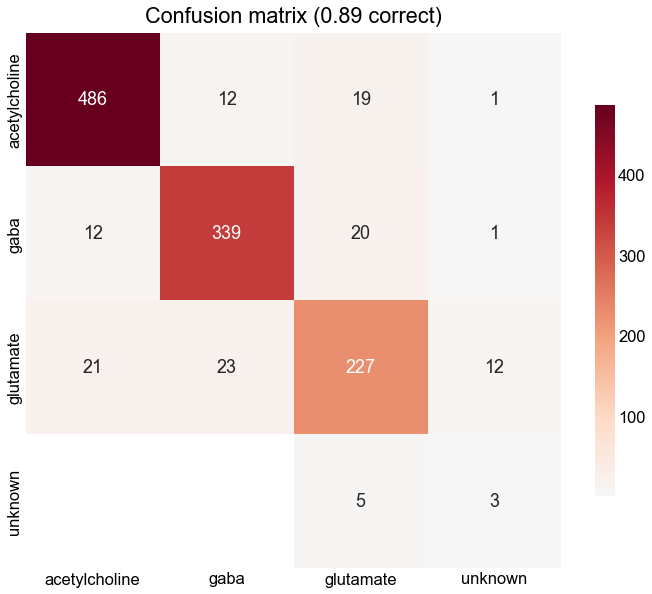

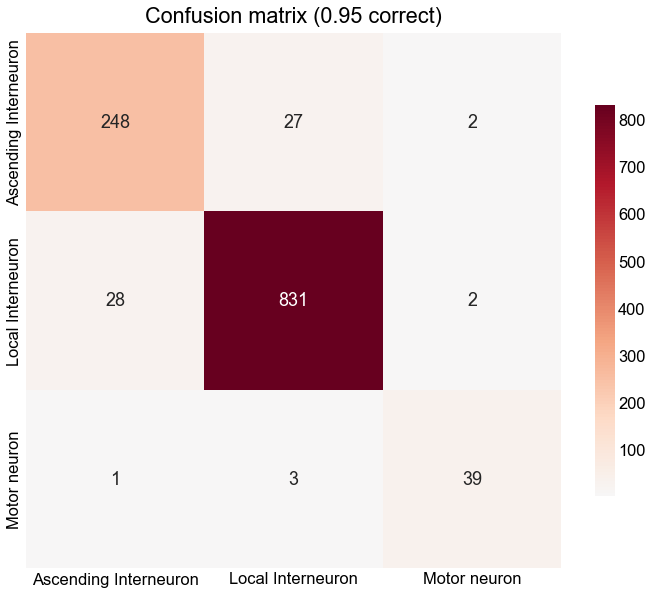

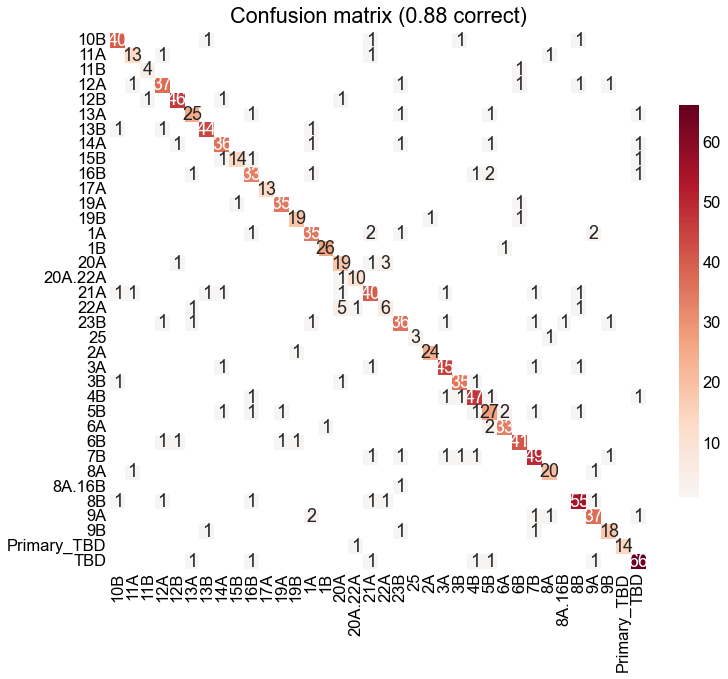

In [6]:

right_matched_meta = right_meta.iloc[match].copy().reset_index()
left_matched_meta = left_meta.copy().reset_index()
matched_meta = left_matched_meta.join(
    right_matched_meta, lsuffix="_left", rsuffix="_right"
)

fields = ["predicted_nt", "class", "hemilineage"]
for field in fields:
    confusionplot(
        matched_meta[field + "_left"].fillna("unknown").values,
        matched_meta[field + "_right"].fillna("unknown").values,
        xticklabels=1,
        yticklabels=1,
        figsize=(12, 12),
    )

## Confusion matrices for the incorrect matches only

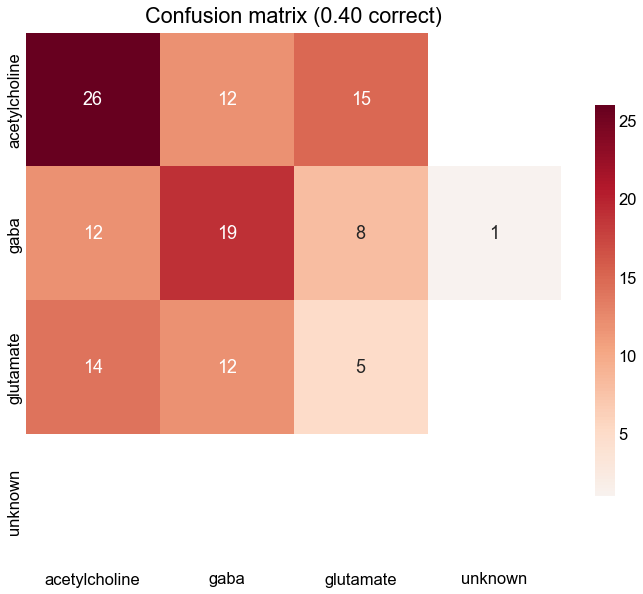

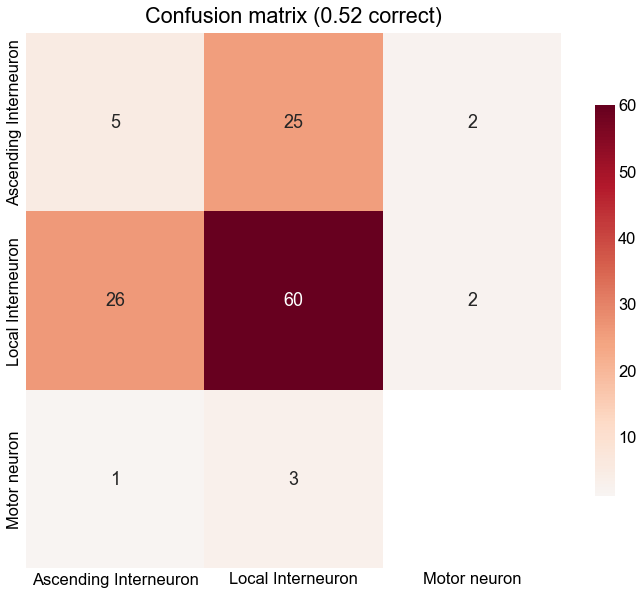

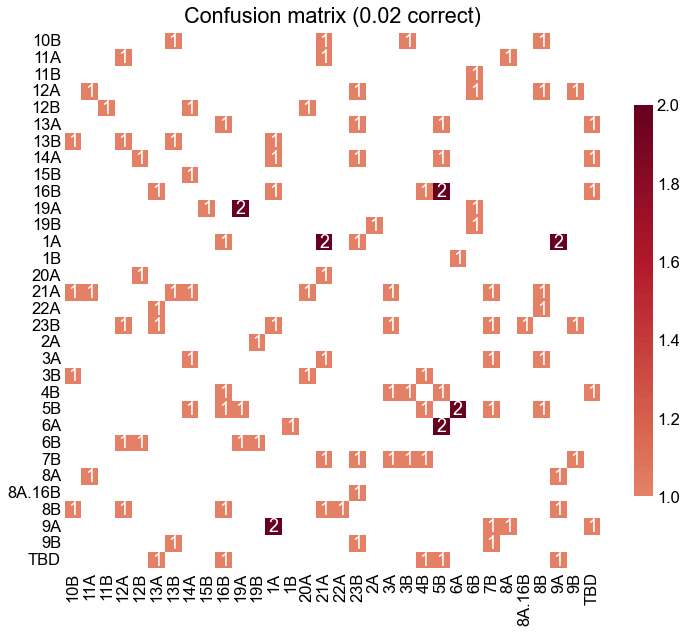

In [7]:
incorrect_meta = matched_meta[matched_meta["group_left"] != matched_meta["group_right"]]
for field in fields:
    confusionplot(
        incorrect_meta[field + "_left"].fillna("unknown").values,
        incorrect_meta[field + "_right"].fillna("unknown").values,
        xticklabels=1,
        yticklabels=1,
        figsize=(12, 12),
    )

## Confusion matrices for the correct matches only

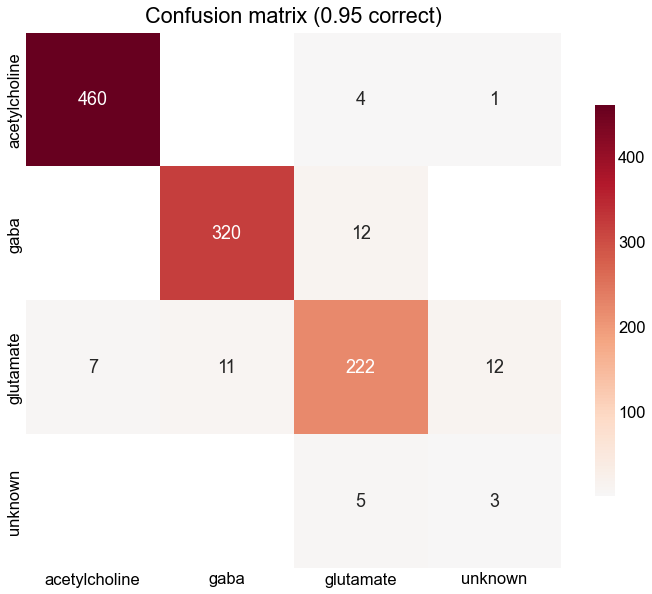

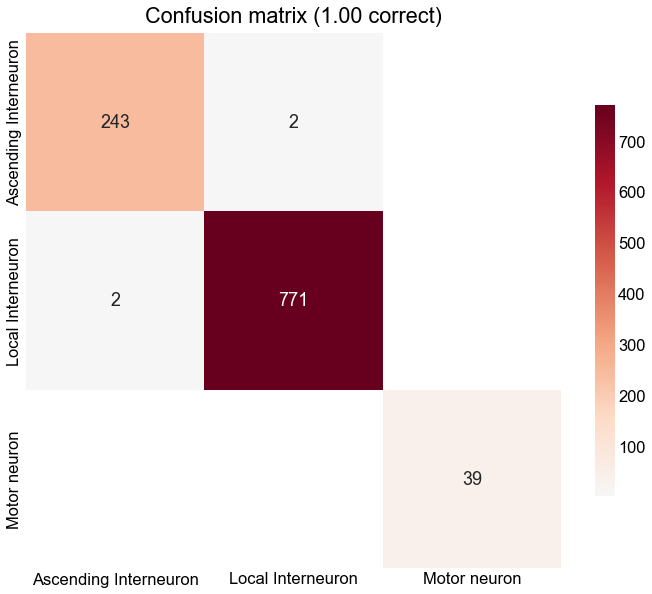

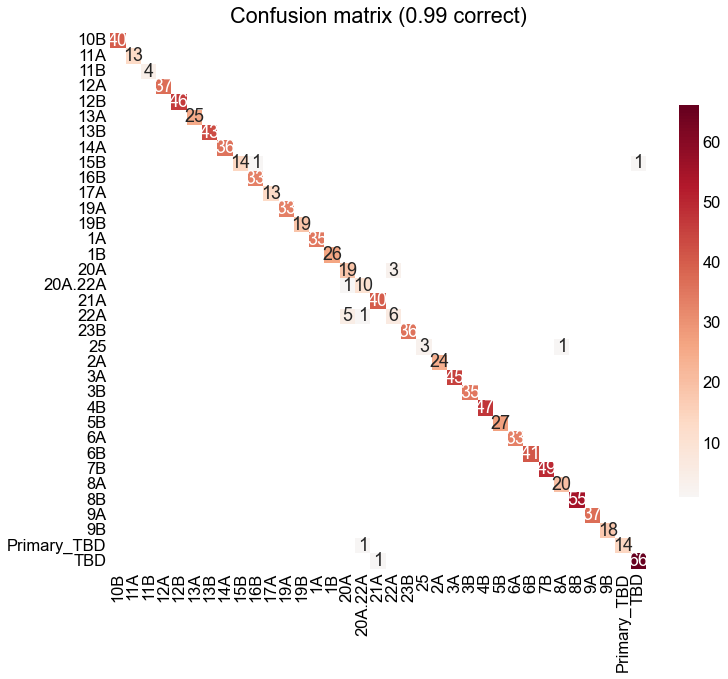

In [8]:
correct_meta = matched_meta[matched_meta["group_left"] == matched_meta["group_right"]]
for field in fields:
    confusionplot(
        correct_meta[field + "_left"].fillna("unknown").values,
        correct_meta[field + "_right"].fillna("unknown").values,
        xticklabels=1,
        yticklabels=1,
        figsize=(12, 12),
    )